# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
from math import sqrt

from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

from shapely import MultiPolygon, unary_union, Point
import geopandas

import matplotlib.pyplot as plt
from matplotlib import colors, colormaps

from data import *
from generation import *

from geomloss import SamplesLoss
import time

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cuda


In [3]:
os.chdir('./Data')
dep = geopandas.read_file("admin-departement.shp") 
dep_2154 = dep.to_crs(2154)
dep_2154.head()

,code_insee,nom,nuts3,wikipedia,geometry
0,31,Haute-Garonne,FR623,fr:Haute-Garonne,"POLYGON ((577524.810 6238730.771, 577904.860 6..."


In [4]:
filename = "pdd.geojson"
gdf_secteurs = geopandas.read_file(filename)
zones = union_iris(gdf_secteurs, "cis1" , True, ['MONTGISCARD', 'AUSSONNE', 'TOULOUSE - ATLANTA', 'TOULOUSE - CARSALADE', 'TOULOUSE - DELRIEU'])

# Stats

In [5]:
os.getcwd()

'/media/michael/Fichiers/Fac/Thèse 1/Code/Git_version/Data'

In [6]:
df_raw = pd.read_csv("./raw_data.csv") 
df_tvae = pd.read_csv("./resample_tvae.csv") 
df_gan = pd.read_csv("./resample_gan.csv") 
df_ctgan = pd.read_csv("./resample_ctgan.csv") 
df_ddpm = pd.read_csv("./resample_ddpm.csv") 
df_tiny = pd.read_csv("./resample_tiny.csv") 

# if resampling, unquote the following:

df_tvae = df_tvae.drop(columns=["area_name"])
df_gan = df_gan.drop(columns=["area_name"])
df_ctgan = df_ctgan.drop(columns=["area_name"])
df_ddpm = df_ddpm.drop(columns=["area_name"])
df_tiny = df_tiny.drop(columns=["area_name"])

In [7]:
df_ddpm.head()

,Coord X,Coord Y,Duration,Day,Month,Hour,Incident
0,572709.368182,6.277876e+06,38,52,2,15,10
1,572545.550167,6.276899e+06,38,46,2,10,2
2,571918.338052,6.274543e+06,34,132,5,18,24
3,571459.136565,6.280166e+06,75,202,7,19,4
4,572053.806689,6.281747e+06,59,192,7,12,31


## Shuffling

In [8]:
start_time = time.time()
df_shuffle = df_raw.sample(frac=1, replace=True).reset_index(drop=True)
shuffle_time = time.time() - start_time
print(shuffle_time)
df_shuffle.head()

0.003160238265991211


,Coord X,Coord Y,Month,Day,Hour,Duration,Incident
0,568488.00,6296205.0,6,175,16,151.0,3
1,580771.00,6287885.0,6,166,3,38.0,1
2,524586.00,6256642.0,11,329,17,93.0,1
3,552136.00,6269434.0,1,2,18,107.0,16
4,569805.44,6279890.5,5,147,2,64.0,1


## Independant Sampling

In [9]:
df_random = pd.DataFrame(columns=df_raw.columns)
start_time = time.time()
df_random[['Coord X', 'Coord Y']] = df_raw.iloc[:, :2].sample(frac=1, random_state=42).reset_index(drop=True)
df_random['Month'] = df_raw.iloc[:, 2].sample(frac=1, random_state=43).reset_index(drop=True)
df_random['Day'] = df_raw.iloc[:, 3].sample(frac=1, random_state=45).reset_index(drop=True)
df_random['Hour'] = df_raw.iloc[:, 4].sample(frac=1, random_state=46).reset_index(drop=True)
df_random['Duration'] = df_raw.iloc[:, 5].sample(frac=1, random_state=47).reset_index(drop=True)
df_random['Incident'] = df_raw.iloc[:, 6].sample(frac=1, random_state=48).reset_index(drop=True)
random_time = time.time() - start_time
print(random_time)
df_random.head()

0.015872478485107422


,Coord X,Coord Y,Month,Day,Hour,Duration,Incident
0,533907.94,6225431.0,2,229,16,71.0,39
1,574206.25,6279197.0,2,136,13,107.0,20
2,571439.90,6275728.5,4,25,9,73.0,1
3,577817.00,6269634.0,10,46,15,116.0,55
4,531582.50,6228870.0,6,241,17,327.0,7


# Metrics

In [10]:
names = ["0_Raw", "1_Shuffle", "2_Random", "3_TVAE", "4_GAN", "5_CTGAN", "6_TabDiff", "7_TinyDiff"]
dfs = [df_raw, df_shuffle, df_random, df_tvae, df_gan, df_ctgan, df_ddpm, df_tiny]

## Standard Metrics

In [11]:
cols = ["Coord X", "Coord Y", "Month", "Day", "Hour", "Duration", "Incident"]

df_one_v = pd.DataFrame(columns=cols)
df_one_v

,Coord X,Coord Y,Month,Day,Hour,Duration,Incident


In [12]:
print([df.shape for df in dfs])

[(53467, 7), (53467, 7), (53467, 7), (43934, 7), (46823, 7), (48308, 7), (53467, 7), (53467, 7)]


In [13]:
names2 = ["RAW", "TVAE", "GAN", "CTGAN", "TabDiff", "TinyDiff"]
dfs2 = [df_raw, df_tvae, df_gan, df_ctgan, df_ddpm, df_tiny]

In [14]:
cols = ["Coord X", "Coord Y", "Month", "Day", "Hour", "Duration", "Incident"]

df_one_v = pd.DataFrame()

for df, name in zip(dfs2, names2):

    df_one_v.loc[name, df.columns] = df.mean().to_list()
    # df_one_v.loc[name, df.columns] = df.std().to_list()
    # df_one_v.loc[name, :] = df.median()
    # df_one_v.loc[name, :] = df.mode()
    # df_one_v.loc[name, df.columns] = df.min().to_list()
    # df_one_v.loc[name, df.columns] = df.max().to_list()
        
    

df_one_v = df_one_v.reindex(sorted(df_one_v.index), axis=0)

In [15]:
print(df_one_v.astype(int))

          Coord X  Coord Y  Month  Day  Hour  Duration  Incident
CTGAN      569838  6275451      6  168    13        87        11
GAN        566140  6270346      6  177    13       127        12
RAW        566973  6271183      6  179    13        88        11
TVAE       570619  6274760      6  158    16        85         1
TabDiff    567042  6271121      6  180    13        90        11
TinyDiff   567051  6271056      6  180    13        87        10


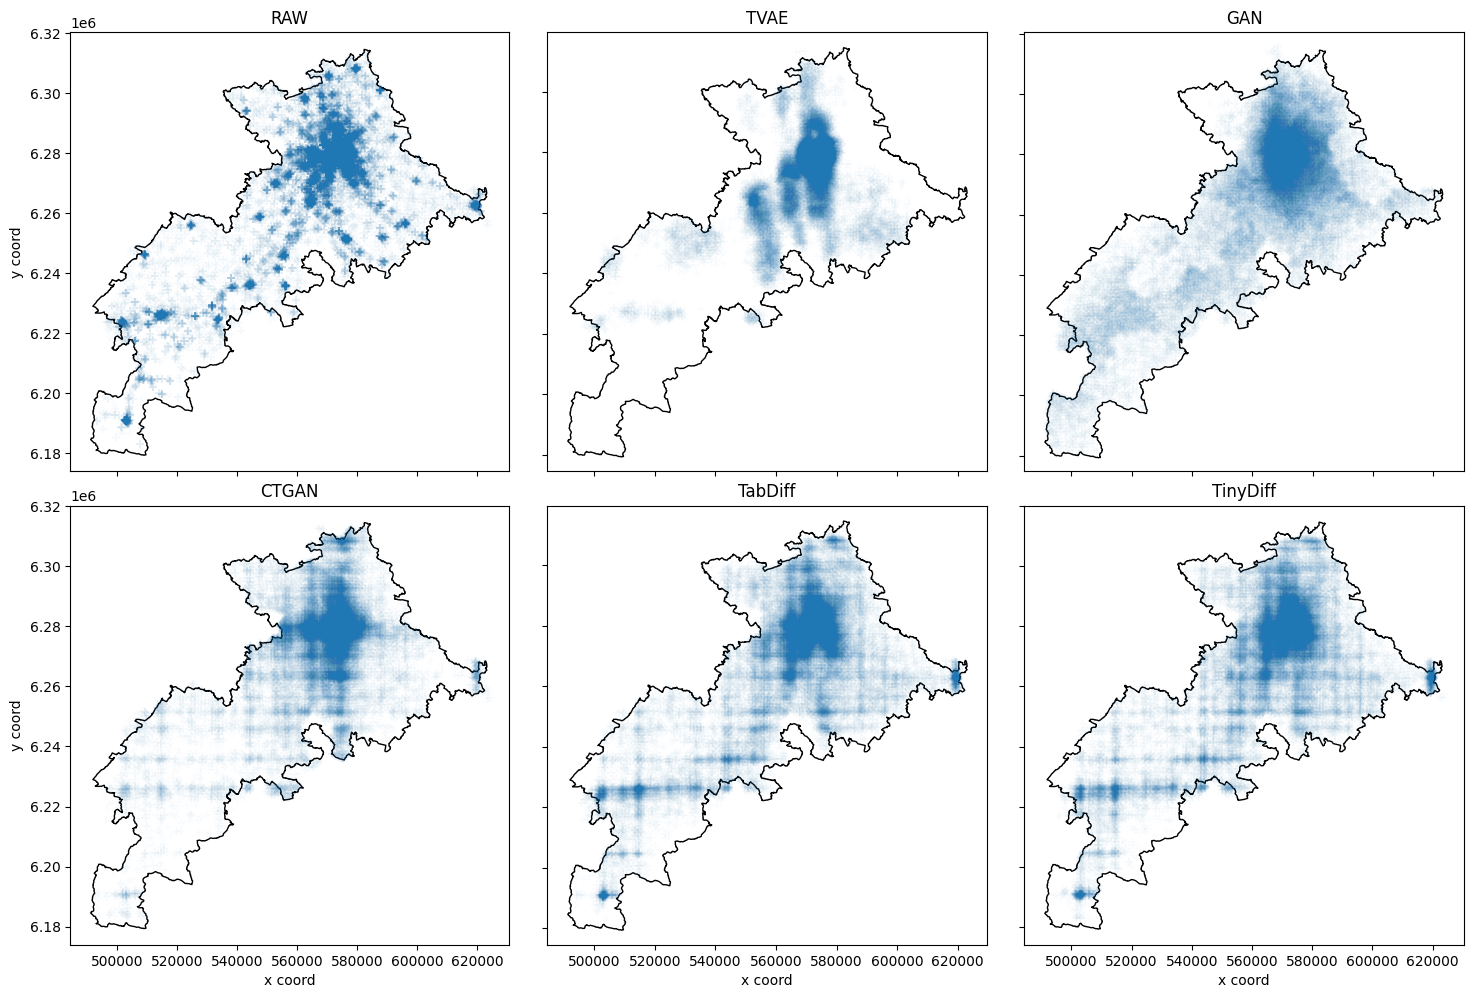

In [16]:
# COORD

fig, axs = plt.subplots(2, 3, figsize = (15, 10))

i, j = 0, 0
for df, name in zip(dfs2, names2):
    

    dep_2154.plot(ax=axs[i, j], color='white', edgecolor='black', aspect=1)
    axs[i, j].scatter(df["Coord X"], df["Coord Y"], marker="+", alpha=0.02)
    axs[i, j].set_title(name)
    axs[i, j].set_box_aspect(1)
    j += 1
    if j > 2:
        i += 1
        j = 0

for ax in axs.flat:
    ax.set(xlabel='x coord', ylabel='y coord')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.tight_layout()
    
plt.savefig('Coord Xy_by_model.png')

RAW
TVAE


/tmp/ipykernel_25232/1538201782.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  zones.loc[:,'nb_inter'] = zones['area'].map(d_cis_inter).fillna(0)


GAN


/tmp/ipykernel_25232/1538201782.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  zones.loc[:,'nb_inter'] = zones['area'].map(d_cis_inter).fillna(0)


CTGAN
TabDiff
TinyDiff


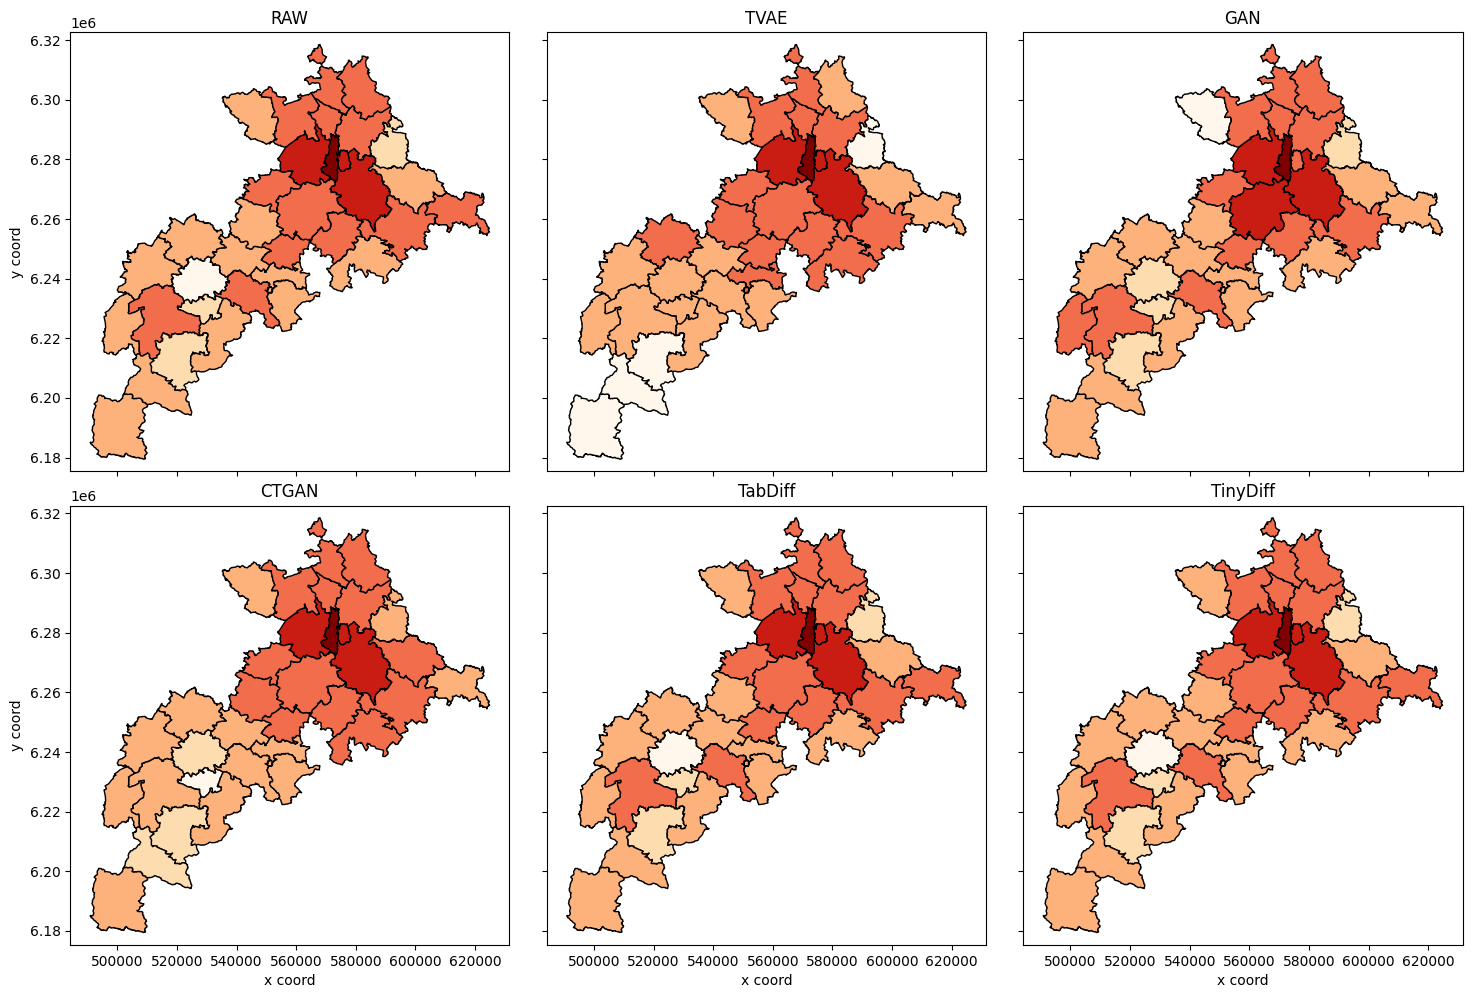

In [17]:
fig, axs = plt.subplots(2, 3, figsize = (15, 10))

i, j = 0, 0
for df, name in zip(dfs2, names2):
    
    print(name)
    
    df_secteur_inter = pd.DataFrame()

    gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['Coord X'], df['Coord Y']), crs="2154")
    df_secteur_inter['area_name'] = gdf["geometry"].apply(get_point_in_area, args=(zones,))
    d_cis_inter ={k:v for k, v in df_secteur_inter['area_name'].value_counts().items()}
    zones.loc[:,'nb_inter'] = zones['area'].map(d_cis_inter).fillna(0)
    zones.plot(ax=axs[i, j], column="nb_inter", cmap='OrRd', scheme='percentiles', legend=False, edgecolor='black')
    # axs[i, j].scatter(df.Coord X, df.Coord Y, marker="+", alpha=0.02)
    axs[i, j].set_title(name)
    axs[i, j].set_box_aspect(1)
    j += 1
    if j > 2:
        i += 1
        j = 0

for ax in axs.flat:
    ax.set(xlabel='x coord', ylabel='y coord')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.tight_layout()
    
plt.savefig('areas_by_model.png')

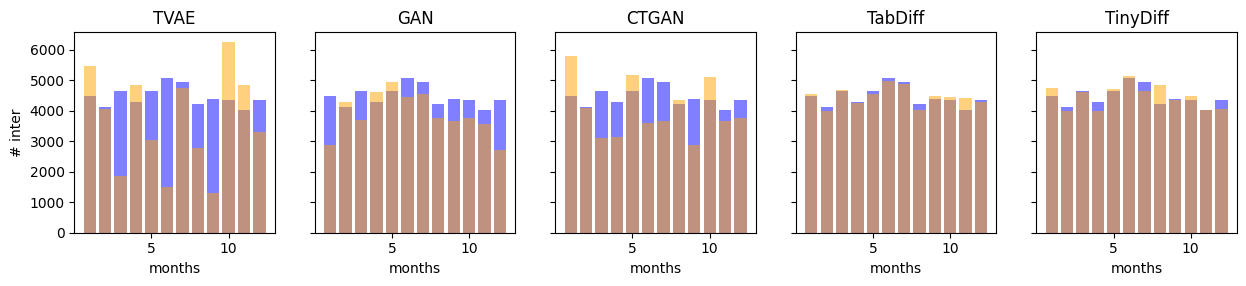

In [18]:
# Month

fig, axs = plt.subplots(1, 5, figsize = (15, 10), sharey = True)

i, j = 0, 0

vcraw = df_raw.Month.value_counts().sort_index()

for df, name in zip(dfs2[1:], names2[1:]):
    

    vcres = df.Month.value_counts().sort_index()

    axs[i].bar(vcraw.index, vcraw.values, color='blue', alpha = .5)
    axs[i].bar(vcres.index, vcres.values, color='orange', alpha = .5)
    axs[i].set_title(name)
    axs[i].set_box_aspect(1)
    i += 1

for ax in axs.flat:
    ax.set(xlabel='months', ylabel='# inter')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.savefig('inter_by_month.png')

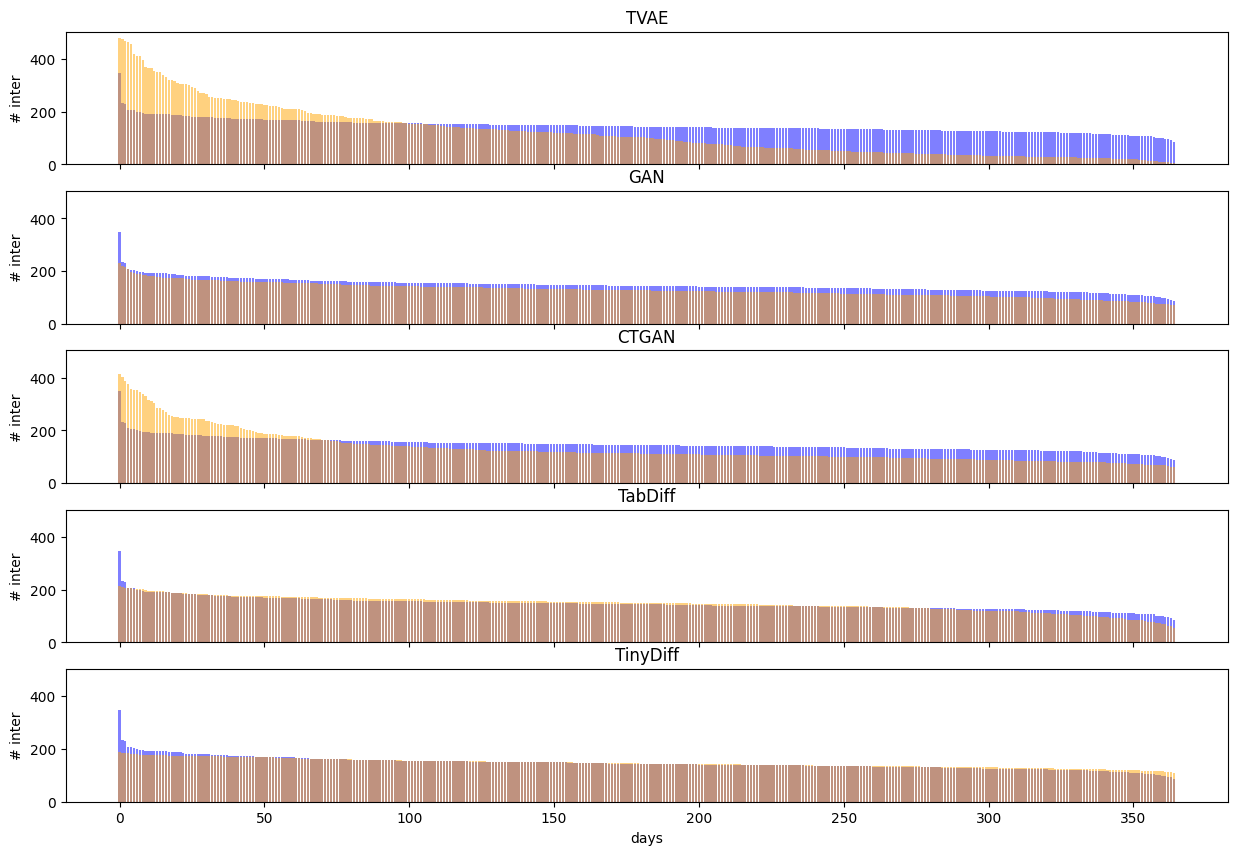

In [19]:
# Day

fig, axs = plt.subplots(5, 1, figsize = (15, 10), sharey = True)

i, j = 0, 0

vcraw = df_raw.Day.value_counts().reset_index(drop=True)

for df, name in zip(dfs2[1:], names2[1:]):
        
    vcres = df.Day.value_counts().reset_index(drop=True)

    axs[i].bar(vcraw.index, vcraw.values, color='blue', alpha = .5)
    axs[i].bar(vcres.index, vcres.values, color='orange', alpha = .5)
    axs[i].set_title(name)
    # axs[i].set_box_aspect(1)

    i += 1

for ax in axs.flat:
    ax.set(xlabel='days', ylabel='# inter')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.savefig('inter_by_day.png')

## Wasserstein

In [20]:
names = ["RAW", "Shuffle", "Random", "TVAE", "GAN", "CTGAN", "TabDiff", "TinyDiff"]
dfs = [df_raw, df_shuffle, df_random, df_tvae, df_gan, df_ctgan, df_ddpm, df_tiny]

df_metrics = pd.DataFrame(columns = names)
df_metrics

,RAW,Shuffle,Random,TVAE,GAN,CTGAN,TabDiff,TinyDiff


In [21]:
norm_real_df=(df_raw-df_raw.min())/(df_raw.max()-df_raw.min())
Loss = SamplesLoss("sinkhorn", p=2, blur=0.05, scaling=0.9)

for df, name in zip(dfs, names):
    
    print(name)
    
    norm_fake_df=(df-df.min())/(df.max()-df.min())

    real = torch.FloatTensor(norm_real_df.to_numpy()).contiguous().to(device)
    fake = torch.FloatTensor(norm_fake_df.to_numpy()).contiguous().to(device)  
    Wass_xy = Loss(real, fake)
    torch.cuda.synchronize()
    df_metrics.loc["W_dist", name] = Wass_xy.item()
    

RAW
Shuffle
Random
TVAE
GAN
CTGAN
TabDiff
TinyDiff


In [22]:
df_metrics

,RAW,Shuffle,Random,TVAE,GAN,CTGAN,TabDiff,TinyDiff
W_dist,0.0,0.000625,0.049449,0.450705,0.327402,0.40454,0.345934,0.43381


## Adding areas

In [23]:
os.getcwd()

'/media/michael/Fichiers/Fac/Thèse 1/Code/Git_version/Data'

In [24]:
filename = "pdd.geojson"
gdf_areas = geopandas.read_file(filename)
zones = union_iris(gdf_areas, "cis1" , True, ['MONTGISCARD', 'AUSSONNE', 'TOULOUSE - ATLANTA', 'TOULOUSE - CARSALADE', 'TOULOUSE - DELRIEU'])
# zones['centroid'] = zones['geometry'].apply(lambda x : x.centroid)
zones['area'] = zones['geometry'].apply(lambda x : x.area)

In [25]:
for df, name in zip(dfs, names):
    gdf_fake = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['Coord X'], df['Coord Y']), crs="2154")
    df['area_name'] = gdf_fake["geometry"].apply(get_point_in_area, args=(zones,))    
    print(name, "done")

RAW done
Shuffle done
Random done
TVAE done
GAN done
CTGAN done
TabDiff done
TinyDiff done


In [26]:
for df, name in zip(dfs, names):

    df.to_csv(name+"_area.csv", index=False, header=True)

In [27]:
dfs2 = []
for df2, name in zip(dfs, names):
    df2 = pd.read_csv("./" + name + "_area.csv") 
    dfs2.append(df2)

## KL divergence

In [28]:
names = ["RAW", "Shuffle", "Random", "TVAE", "GAN", "CTGAN", "TabDiff", "TinyDiff"]
dfs = [df_raw, df_shuffle, df_random, df_tvae, df_gan, df_ctgan, df_ddpm, df_tiny]
dfs2 = []
for df2, name in zip(dfs, names):
    df2 = pd.read_csv("./" + name + "_area.csv") 
    dfs2.append(df2)

In [29]:
df_metrics = pd.DataFrame(columns = names)

In [30]:
def kl_divergence(a, b):

    return sum(a[i] * np.log(a[i]/b[i]) for i in range(len(a)))

# dist1 = df_raw.Incident.value_counts(normalize=True).values
# dist2 = df_ddpm.Incident.value_counts(normalize=True).values
# kl_divergence(dist1,dist2)

In [31]:
cols = ["area_name", 'Month', 'Day', 'Hour', 'Incident']

df_metrics = pd.DataFrame()

for df, name in zip(dfs2[4:], names[4:]): 

    for col in cols:

        # print(col)

        dist1 = dfs2[0][col].value_counts(normalize=True).values
        dist2 = df[col].value_counts(normalize=True).values


        df_metrics.loc["KLD " + col, name] = kl_divergence(dist1, dist2)
    

In [32]:
df_metrics

,GAN,CTGAN,TabDiff,TinyDiff
KLD area_name,0.009351,0.031066,0.000053,0.000053
KLD Month,0.006380,0.010886,0.000129,0.000532
KLD Day,0.001968,0.034598,0.003547,0.001995
KLD Hour,0.010088,0.059505,0.001933,0.005913
KLD Incident,0.050475,0.000532,0.000445,0.012140


## Jensen-Shannon divergence

In [33]:
dfs2 = []
for df2, name in zip(dfs, names):
    df2 = pd.read_csv("./" + name + "_area.csv") 
    dfs2.append(df2)

In [34]:
for df in dfs2:
    print(df.shape)

(53467, 8)
(53467, 8)
(53467, 8)
(43934, 8)
(46823, 8)
(48308, 8)
(53467, 8)
(53467, 8)


In [35]:
def calculate_probability_distribution(feature_values):
    """Calculate probability distribution for categorical feature"""
    unique_values, counts = np.unique(feature_values, return_counts=True)
    return (counts / len(feature_values))

def kl_divergence(p, q):
    """Compute KL divergence"""
    return np.sum(p * np.log(p / q))

def jensen_shannon_divergence(p, q):
    """Compute Jensen-Shannon divergence"""
    m = (p + q) / 2
    return np.sqrt((kl_divergence(p, m) + kl_divergence(q, m)) / 2)

def calculate_jsd(feature_real, feature_fake):
    """Calculate Jensen-Shannon divergence for categorical features"""
    
    p = calculate_probability_distribution(feature_real)
    q = calculate_probability_distribution(feature_fake)
    

    return jensen_shannon_divergence(p, q)

In [36]:
df_metrics = pd.DataFrame(columns = names)

real = df_raw[['Month', 'Day', 'Hour', 'Incident', 'area_name']]

for df, name in zip(dfs, names):
    
    fake = df[['Month', 'Day', 'Hour', 'Incident', 'area_name']]

    
    for categ in fake.columns:

        feature_real = real[categ].to_numpy()
        feature_fake = fake[categ].to_numpy()

        p_values, p_counts = np.unique(feature_real, return_counts=True)
        q_values, q_counts = np.unique(feature_fake, return_counts=True)

        new_q_values, new_q_counts = [], []

        for qv, qc in zip(q_values, q_counts):

            if qv in p_values:

                new_q_values.append(qv), new_q_counts.append(qc)

        for pv, pc in zip(p_values, p_counts):

            if pv not in q_values:

                new_q_values.append(pv), new_q_counts.append(1e-7)



        p = (p_counts / len(p_values))
        q = (np.array(new_q_counts) / len(new_q_values))

        df_metrics.loc["JSD "+categ, name] = jensen_shannon_divergence(p, q)

        

In [37]:
df_metrics

,RAW,Shuffle,Random,TVAE,GAN,CTGAN,TabDiff,TinyDiff
JSD Month,0.0,0.320644,0.0,11.523821,4.77867,5.708861,0.795744,1.358304
JSD Day,0.0,0.354033,0.0,3.34165,1.094383,1.908776,1.057945,0.751324
JSD Hour,0.0,0.343309,0.0,23.126867,3.252543,8.702532,1.279053,3.223378
JSD Incident,0.0,0.349727,0.0,17.260921,3.767597,1.137681,0.420836,1.682664
JSD area_name,0.0,0.343331,0.0,19.000482,4.757799,4.696196,0.144232,0.144232


## Maximum Mean Discrepancy

In [38]:
def mmd_linear(X, Y):
    """MMD using linear kernel (i.e., k(x,y) = <x,y>)
    Note that this is not the original linear MMD, only the reformulated and faster version.
    The original version is:
        def mmd_linear(X, Y):
            XX = np.dot(X, X.T)
            YY = np.dot(Y, Y.T)
            XY = np.dot(X, Y.T)
            return XX.mean() + YY.mean() - 2 * XY.mean()

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Returns:
        [scalar] -- [MMD value]
    """
    delta = X.mean(0) - Y.mean(0)
    return delta.dot(delta.T)


def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = pairwise.rbf_kernel(X, X, gamma)
    YY = pairwise.rbf_kernel(Y, Y, gamma)
    XY = pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()


def mmd_poly(X, Y, degree=2, gamma=1, coef0=0):
    """MMD using polynomial kernel (i.e., k(x,y) = (gamma <X, Y> + coef0)^degree)

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        degree {int} -- [degree] (default: {2})
        gamma {int} -- [gamma] (default: {1})
        coef0 {int} -- [constant item] (default: {0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = pairwise.polynomial_kernel(X, X, degree, gamma, coef0)
    YY = pairwise.polynomial_kernel(Y, Y, degree, gamma, coef0)
    XY = pairwise.polynomial_kernel(X, Y, degree, gamma, coef0)
    return XX.mean() + YY.mean() - 2 * XY.mean()


In [39]:
df_metrics = pd.DataFrame(columns = names)

In [40]:
cols = ["Coord X", "Coord Y", 'Month', 'Day', 'Hour', 'Duration']

to_QT = df_raw[cols].values

normalizer = MinMaxScaler()

a = normalizer.fit_transform(to_QT).astype(np.float32)

for df, name in zip(dfs, names):
    
    print(name)
  
    to_QT = df[cols].values

    normalizer = MinMaxScaler()

    b = normalizer.fit_transform(to_QT).astype(np.float32)
    
    df_metrics.loc["MMD_lin", name] = mmd_linear(a, b)

    # df_metrics.loc["MMD_pol", name] = mmd_poly(a, b)


RAW
Shuffle
Random
TVAE
GAN
CTGAN
TabDiff
TinyDiff


In [41]:
df_metrics

,RAW,Shuffle,Random,TVAE,GAN,CTGAN,TabDiff,TinyDiff
MMD_lin,0.0,0.000013,0.0,0.164945,0.076352,0.002664,0.000071,0.00006


## Variability

In [42]:
df_metrics = pd.DataFrame(columns = names)

In [43]:
cols = ['Month', 'Day', 'Hour', 'Duration','Incident', 'area_name']

for df, name in zip(dfs, names):
    
    for col in cols:
    
        df_test = pd.DataFrame(df_raw[col].value_counts().sort_index())
        df_test["sample"] = df[col].value_counts().sort_index()
        df_test["delta"] = (df_test[col] - df_test["sample"]).abs()
        df_test["perc."] = round(df_test["delta"] / df_test[col] * 100)

#         df_metrics.loc["Dmin_"+col, name] = df_test["delta"].min()
#         df_metrics.loc["Dmax_"+col, name] = df_test["delta"].max()
        df_metrics.loc["% min "+col, name] = df_test["perc."].min()
        df_metrics.loc["% max "+col, name] = df_test["perc."].max()

In [44]:
df_metrics

,RAW,Shuffle,Random,TVAE,GAN,CTGAN,TabDiff,TinyDiff
% min Month,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0
% max Month,0.0,3.0,0.0,70.0,38.0,34.0,10.0,15.0
% min Day,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
% max Day,0.0,26.0,0.0,257.0,64.0,181.0,81.0,57.0
% min Hour,0.0,0.0,0.0,5.0,3.0,5.0,1.0,1.0
% max Hour,0.0,6.0,0.0,447.0,57.0,142.0,16.0,36.0
% min Duration,0.0,0.0,0.0,38.0,2.0,0.0,0.0,0.0
% max Duration,0.0,300.0,0.0,97.0,600.0,300.0,100.0,113.0
% min Incident,0.0,0.0,0.0,71.0,1.0,1.0,0.0,0.0
% max Incident,0.0,14.0,0.0,253.0,462.0,26.0,17.0,75.0


## PRDC

In [45]:
__all__ = ['compute_prdc']


# def compute_pairwise_distance(data_x, data_y=None):
#     """
#     Args:
#         data_x: numpy.ndarray([N, feature_dim], dtype=np.float32)
#         data_y: numpy.ndarray([N, feature_dim], dtype=np.float32)
#     Returns:
#         numpy.ndarray([N, N], dtype=np.float32) of pairwise distances.
#     """
#     if data_y is None:
#         data_y = data_x
#     dists = sklearn.metrics.pairwise_distances(
#         data_x, data_y, metric='euclidean', n_jobs=8)
#     return dists


def get_kth_value(unsorted, k, axis=-1):
    """
    Args:
        unsorted: numpy.ndarray of any dimensionality.
        k: int
    Returns:
        kth values along the designated axis.
    """
    indices = np.argpartition(unsorted, k, axis=axis)[..., :k]
    k_smallests = np.take_along_axis(unsorted, indices, axis=axis)
    kth_values = k_smallests.max(axis=axis)
    return kth_values


def compute_nearest_neighbour_distances(input_features, nearest_k):
    """
    Args:
        input_features: numpy.ndarray([N, feature_dim], dtype=np.float32)
        nearest_k: int
    Returns:
        Distances to kth nearest neighbours.
    """
    distances = torch.cdist(input_features, input_features, p=2, compute_mode = "donot_use_mm_for_euclid_dist")
    radii = get_kth_value(distances.cpu().detach().numpy(), k=nearest_k + 1, axis=-1)
    return radii


def compute_prdc(real_features, fake_features, nearest_k, device):
    """
    Computes precision, recall, density, and coverage given two manifolds.

    Args:
        real_features: numpy.ndarray([N, feature_dim], dtype=np.float32)
        fake_features: numpy.ndarray([N, feature_dim], dtype=np.float32)
        nearest_k: int.
    Returns:
        dict of precision, recall, density, and coverage.
    """

    print('Num real: {} Num fake: {}'
          .format(real_features.shape[0], fake_features.shape[0]))
    
    a = torch.FloatTensor(real_features.to_numpy()).to(device)
    b = torch.FloatTensor(fake_features.to_numpy()).to(device)

    real_nearest_neighbour_distances = compute_nearest_neighbour_distances(a, nearest_k)
    fake_nearest_neighbour_distances = compute_nearest_neighbour_distances(b, nearest_k)
    distance_real_fake = torch.cdist(a, b, p=2).cpu().detach().numpy()

    precision = (
            distance_real_fake <
            np.expand_dims(real_nearest_neighbour_distances, axis=1)
    ).any(axis=0).mean()

    recall = (
            distance_real_fake <
            np.expand_dims(fake_nearest_neighbour_distances, axis=0)
    ).any(axis=1).mean()

    density = (1. / float(nearest_k)) * (
            distance_real_fake <
            np.expand_dims(real_nearest_neighbour_distances, axis=1)
    ).sum(axis=0).mean()

    coverage = (
            distance_real_fake.min(axis=1) <
            real_nearest_neighbour_distances
    ).mean()

    return dict(precision=precision, recall=recall,
                density=density, coverage=coverage)

In [46]:
df_raw.head()

,Coord X,Coord Y,Month,Day,Hour,Duration,Incident,area_name
0,573603.00,6280852.0,1,0,0,54.0,4,5.299134e+07
1,558522.00,6263928.0,1,0,0,32.0,18,3.043763e+08
2,574303.94,6279553.0,1,0,0,25.0,7,2.329456e+07
3,571710.70,6305442.5,1,0,0,167.0,27,1.365294e+08
4,569896.00,6265672.0,1,0,0,41.0,1,3.043763e+08


In [47]:
df_raw = pd.read_csv("./raw_data.csv") 
df_tvae = pd.read_csv("./resample_tvae.csv") 
df_gan = pd.read_csv("./resample_gan.csv") 
df_ctgan = pd.read_csv("./resample_ctgan.csv") 
df_ddpm = pd.read_csv("./resample_ddpm.csv") 
df_tiny = pd.read_csv("./resample_tiny.csv") 


# df_shuffle = df_shuffle.drop(columns=["area_name"])
# df_random = df_random.drop(columns=["area_name"])
df_tvae = df_tvae.drop(columns=["area_name"])
df_gan = df_gan.drop(columns=["area_name"])
df_ctgan = df_ctgan.drop(columns=["area_name"])
df_ddpm = df_ddpm.drop(columns=["area_name"])
df_tiny = df_tiny.drop(columns=["area_name"])

names2 = ["RAW", "TVAE", "GAN", "CTGAN", "TabDiff", "TinyDiff"]
dfs2 = [df_raw, df_tvae, df_gan, df_ctgan, df_ddpm, df_tiny]

In [48]:
nearest_k = 5
df_prdc = pd.DataFrame()
df_total = pd.DataFrame()

for df, name in zip(dfs2[1:], names2[1:]):
        
    print(name)

    for m in range(1, 13):
        a = df_raw.drop(columns=["Incident"])[df_raw["Month"]==m].astype(np.int64)
        b = df.drop(columns=["Incident"])[df["Month"]==m].astype(np.int64)
        metrics = compute_prdc(real_features= a ,
                           fake_features= b ,
                           nearest_k=nearest_k,
                          device = device)

        p, r, d, c = metrics.values()


        df_prdc.loc[m, "quantity"] = int(a.shape[0])
        df_prdc.loc[m, "precision"] = round(p, 3)
        df_prdc.loc[m, "recall"] = round(r, 3)
        df_prdc.loc[m, "density"] = round(d, 3)
        df_prdc.loc[m, "coverage"] = round(c, 3)

    # df_total.loc[name, "quantity"] = df_prdc["quantity"].sum()
    df_total.loc[name, "precision"] = round(df_prdc["precision"].mean(), 3)
    df_total.loc[name, "recall"] = round(df_prdc["recall"].mean(), 3)
    df_total.loc[name, "density"] = round(df_prdc["density"].mean(), 3)
    df_total.loc[name, "coverage"] = round(df_prdc["coverage"].mean(), 3)

TVAE
Num real: 4482 Num fake: 5458
Num real: 4109 Num fake: 4039
Num real: 4632 Num fake: 1848
Num real: 4281 Num fake: 4839
Num real: 4647 Num fake: 3044
Num real: 5073 Num fake: 1509
Num real: 4952 Num fake: 4750
Num real: 4212 Num fake: 2779
Num real: 4369 Num fake: 1291
Num real: 4353 Num fake: 6252
Num real: 4010 Num fake: 4835
Num real: 4347 Num fake: 3290
GAN
Num real: 4482 Num fake: 2866
Num real: 4109 Num fake: 4291
Num real: 4632 Num fake: 3700
Num real: 4281 Num fake: 4603
Num real: 4647 Num fake: 4931
Num real: 5073 Num fake: 4442
Num real: 4952 Num fake: 4554
Num real: 4212 Num fake: 3773
Num real: 4369 Num fake: 3658
Num real: 4353 Num fake: 3755
Num real: 4010 Num fake: 3557
Num real: 4347 Num fake: 2693
CTGAN
Num real: 4482 Num fake: 5792
Num real: 4109 Num fake: 4098
Num real: 4632 Num fake: 3100
Num real: 4281 Num fake: 3136
Num real: 4647 Num fake: 5171
Num real: 5073 Num fake: 3594
Num real: 4952 Num fake: 3656
Num real: 4212 Num fake: 4354
Num real: 4369 Num fake: 

In [49]:
df_total

,precision,recall,density,coverage
TVAE,0.991,0.900,22.134,0.776
GAN,0.982,0.977,9.795,0.915
CTGAN,0.987,0.996,18.693,0.932
TabDiff,0.990,0.993,18.659,0.973
TinyDiff,0.987,0.994,17.819,0.973


## Correlations

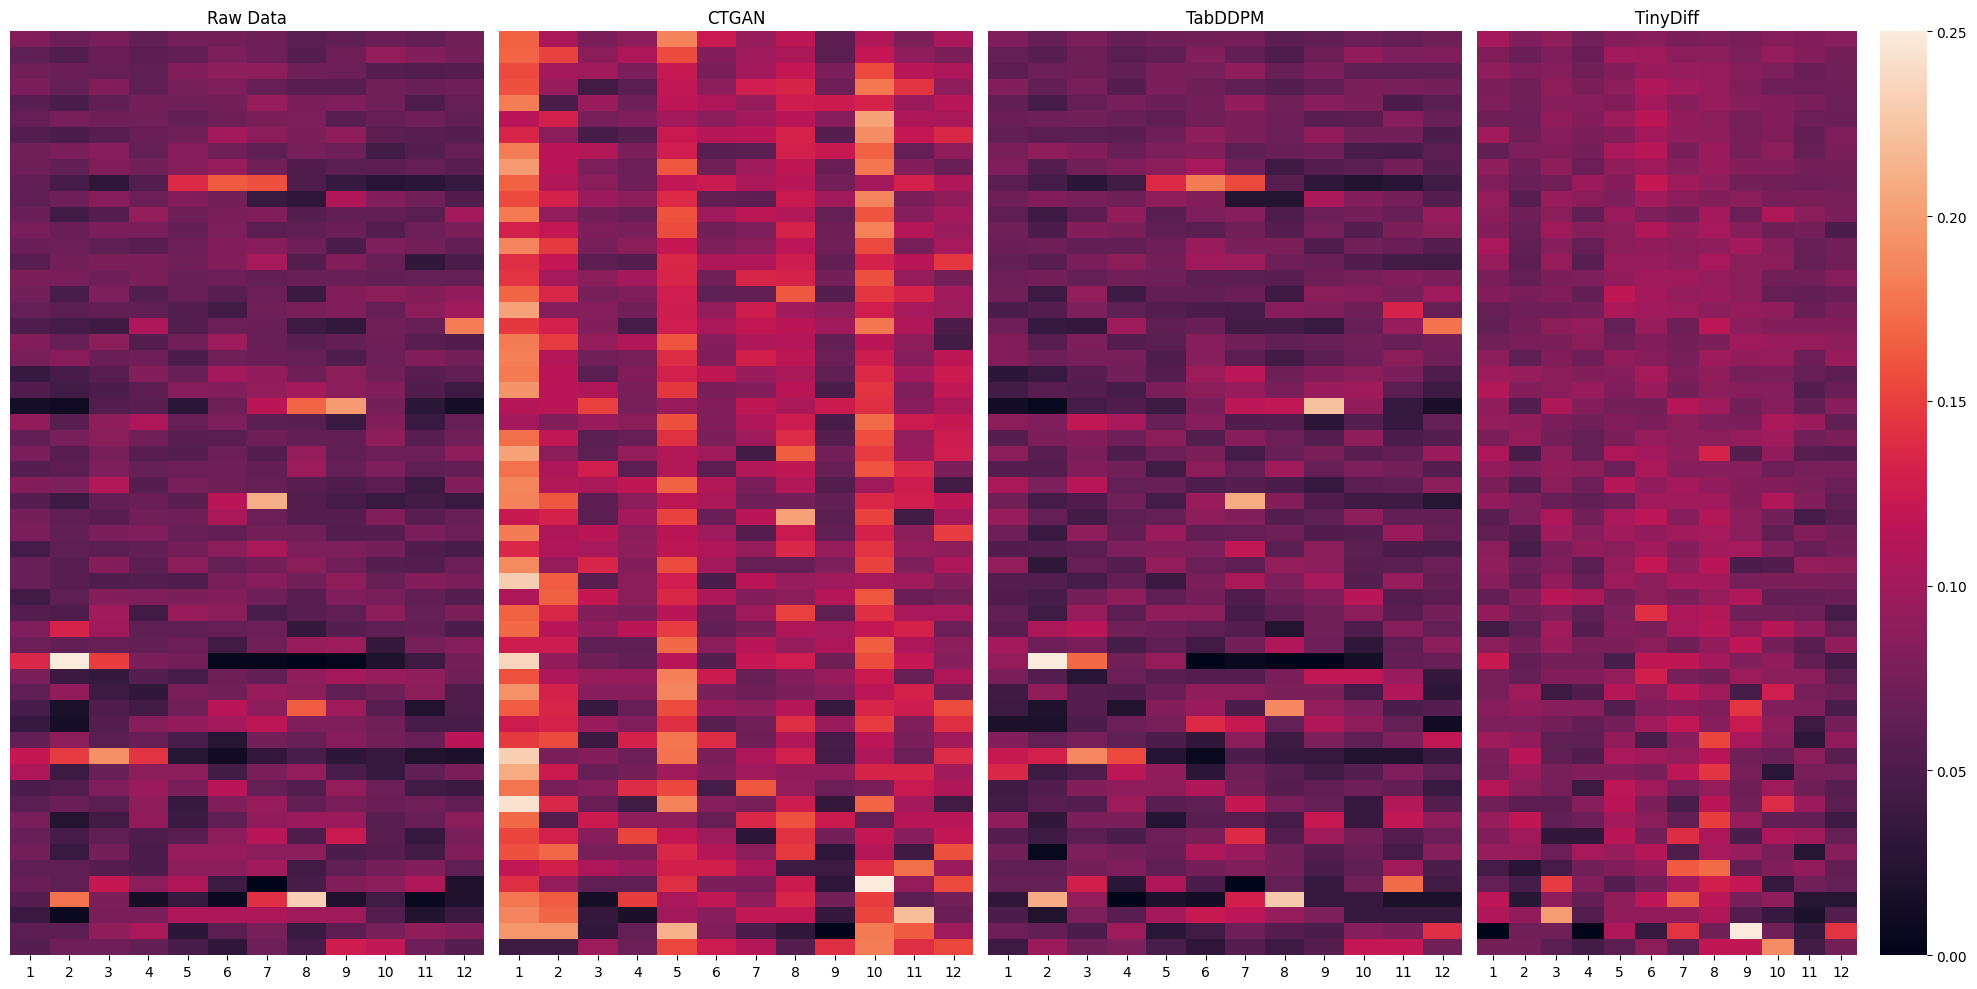

In [50]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 10), gridspec_kw={'width_ratios': [10, 10, 10, 10]})

df_res = compute_x_by_y(df_raw, "Incident", "Month")
data = df_res.div(df_res.sum(axis=1), axis=0)
sns.heatmap(data, ax=ax1, cbar=False, yticklabels=False) 
ax1.set_title("Raw Data")

df_res = compute_x_by_y(df_ctgan, "Incident", "Month")
data = df_res.div(df_res.sum(axis=1), axis=0)
sns.heatmap(data, ax=ax2, cbar=False, yticklabels=False) 
ax2.set_title("CTGAN")

df_res = compute_x_by_y(df_ddpm, "Incident", "Month")
data = df_res.div(df_res.sum(axis=1), axis=0)
sns.heatmap(data, ax=ax3, cbar=False, yticklabels=False) 
ax3.set_title("TabDDPM")

df_res = compute_x_by_y(df_tiny, "Incident", "Month")
data = df_res.div(df_res.sum(axis=1), axis=0)
sns.heatmap(data, ax=ax4, cbar=True, yticklabels=False) 
ax4.set_title("TinyDiff")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.savefig('correlations_4_models.png')
plt.show()